In [1]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype']        = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [2]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(df_, scenario):

        df_p_  = df_[['period', 
                      'technology',
                      'load_zone', 
                      'capacity_mw']].copy()

        df_p_ = df_p_.groupby(['period', 
                               'technology', 
                               'load_zone']).agg('sum').reset_index(drop = False)

        df_p_['scenario'] = scenario

        return df_p_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_new_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario):
        
        #df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']
        #df_['cf'] = df_['power_mw']/df_['capacity_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name  = r'{}/{}'.format(path, scen)
        dispatch_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_dispatch_from_csv(dispatch_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

In [343]:
scen_labels_ = pd.read_csv(path_to_csvs + '/test-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
zone_labels_ = pd.read_csv(path_to_csvs + '/zone_labels.csv') 

In [348]:
capacity_ = _load_capacity(scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-day /Users/Guille/Desktop/india_power/scenarios
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month /Users/Guille/Desktop/india_power/scenarios


In [371]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'scenario']).agg('sum')

    return capacity_.reset_index(drop = False)

grouped_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

idx_ = grouped_capacity_['technology'] == 'Battery'
idx_ = idx_ | (grouped_capacity_['technology'] == 'Hydrogen') 
idx_ = idx_ | (grouped_capacity_['technology'] == 'Pumped Storage')

grouped_capacity_ = grouped_capacity_.loc[~idx_].reset_index(drop = True)
grouped_capacity_ = grouped_capacity_.fillna(0.)

print(grouped_capacity_)

      period technology       load_zone  \
0       2020       Coal  Andhra_Pradesh   
1       2020       Coal  Andhra_Pradesh   
2       2020       Coal           Assam   
3       2020       Coal           Assam   
4       2020       Coal           Bihar   
...      ...        ...             ...   
1163    2050       Wind       Telangana   
1164    2050       Wind   Uttar_Pradesh   
1165    2050       Wind   Uttar_Pradesh   
1166    2050       Wind     West_Bengal   
1167    2050       Wind     West_Bengal   

                                               scenario   capacity_mw  
0     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  13518.618000  
1     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  13518.618000  
2     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...    883.310000  
3     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...    883.310000  
4     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...   6405.500000  
...                                                

In [372]:
dispatch_ = _load_dispatch(scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-day /Users/Guille/Desktop/india_power/scenarios
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month /Users/Guille/Desktop/india_power/scenarios


In [373]:
def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})
    
    return df_.reset_index(drop = False)

grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)

idx_ = grouped_dispatch_['technology'] == 'Battery'
idx_ = idx_ | (grouped_dispatch_['technology'] == 'Hydrogen') 
idx_ = idx_ | (grouped_dispatch_['technology'] == 'Pumped Storage')

grouped_dispatch_ = grouped_dispatch_.loc[~idx_].reset_index(drop = True)
grouped_dispatch_ = grouped_dispatch_.fillna(0.)
print(grouped_dispatch_)

      period technology       load_zone  \
0       2020       Coal  Andhra_Pradesh   
1       2020       Coal  Andhra_Pradesh   
2       2020       Coal           Assam   
3       2020       Coal           Assam   
4       2020       Coal           Bihar   
...      ...        ...             ...   
1163    2050       Wind       Telangana   
1164    2050       Wind   Uttar_Pradesh   
1165    2050       Wind   Uttar_Pradesh   
1166    2050       Wind     West_Bengal   
1167    2050       Wind     West_Bengal   

                                               scenario      power_mw  
0     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  3.572126e+06  
1     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  3.572126e+06  
2     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  0.000000e+00  
3     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  0.000000e+00  
4     VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...  1.936278e+06  
...                                                

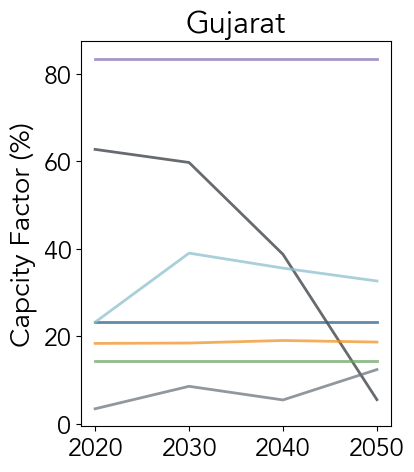

In [377]:
# Plot land use (MHa) for different scenarios
def _plot_capacity_factors(ax, df_1_, df_2_, tech_labels_, scen, load_zone,
                           ylabel       = r'Capcity Factor (%)',
                           legend_title = 'Resource'):
    
    df_1p_ = df_1_.loc[(df_1_['scenario'] == scen) & (df_1_['load_zone'] == load_zone)].reset_index(drop = True)    
    df_2p_ = df_2_.loc[(df_2_['scenario'] == scen) & (df_2_['load_zone'] == load_zone)].reset_index(drop = True)    
    
    for tech in df_1p_['technology'].unique():  
        df_1pp_ = df_1p_.loc[df_1p_['technology'] == tech].sort_values(by = ['period']).reset_index(drop = True)
        df_2pp_ = df_2p_.loc[df_2p_['technology'] == tech].sort_values(by = ['period']).reset_index(drop = True)
        color   = tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0]
        
        cf_ = 100.*(df_1pp_['power_mw']/(df_2pp_['capacity_mw']*24*24))
        ax.plot(df_2pp_['period'], cf_, 
                label = tech,
                color = color,
                alpha = 0.75, 
                lw    = 2.)
    
    #ax.set_xticks(x_, x_)
    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.set_ylabel(ylabel, fontsize = 20)


scen      = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month'
load_zone = 'Gujarat'

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_capacity_factors(ax, grouped_dispatch_, grouped_capacity_, tech_labels_, scen, load_zone)
ax.set_title(f'{load_zone}', fontsize = 22)
plt.show()

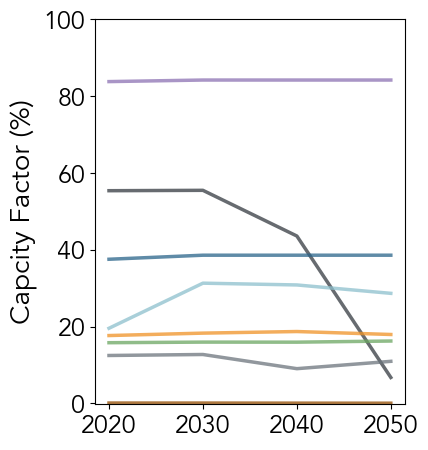

In [395]:
# Plot land use (MHa) for different scenarios
def _plot_capacity_factors(ax, df_1_, df_2_, tech_labels_, scen, 
                           load_zone    = None,
                           ylabel       = r'Capcity Factor (%)',
                           legend_title = 'Resource'):
    
    if load_zone == None:
        df_1_ = df_1_.groupby(['period', 
                               'technology', 
                               'scenario']).agg({'power_mw': 'sum'}).reset_index(drop = False)
    
        df_2_ = df_2_.groupby(['period', 
                               'technology', 
                               'scenario']).agg({'capacity_mw': 'sum'}).reset_index(drop = False)
        
    df_1p_ = df_1_.loc[(df_1_['scenario'] == scen)].reset_index(drop = True)    
    df_2p_ = df_2_.loc[(df_2_['scenario'] == scen)].reset_index(drop = True)    
    
    for tech in df_1p_['technology'].unique():  
        df_1pp_ = df_1p_.loc[df_1p_['technology'] == tech].sort_values(by = ['period']).reset_index(drop = True)
        df_2pp_ = df_2p_.loc[df_2p_['technology'] == tech].sort_values(by = ['period']).reset_index(drop = True)
        color   = tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0]
        
        cf_ = 100.*(df_1pp_['power_mw']/(df_2pp_['capacity_mw']*24*24))

        ax.plot(df_2pp_['period'], cf_, 
                label = tech,
                color = color,
                alpha = 0.75, 
                lw    = 2.5)
    
    ax.set_ylim(-.25, 100)
    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.set_ylabel(ylabel, fontsize = 20)


scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month'

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_capacity_factors(ax, grouped_dispatch_, grouped_capacity_, tech_labels_, scen)

plt.show()

In [393]:
print(scen_labels_['scenario'].unique())

['VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-day'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month']


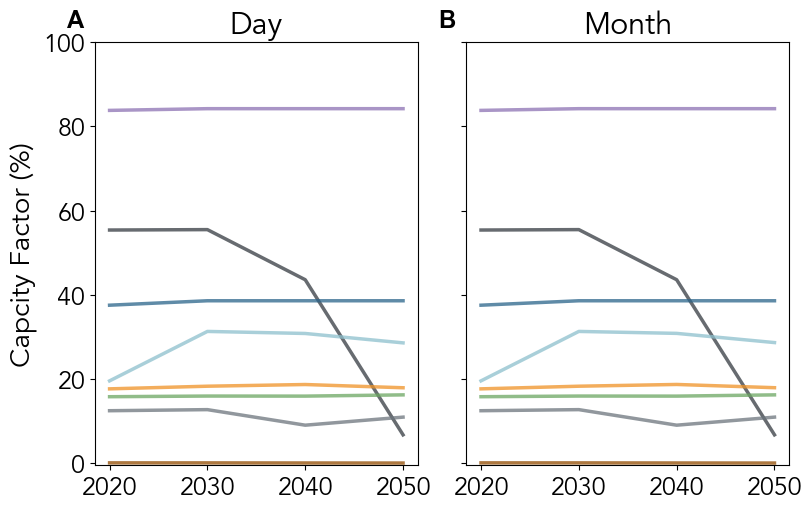

In [394]:

fig, _ax = plt.subplot_mosaic([['A', 'B']], layout      = 'constrained', 
                                            sharey      = True,
                                            sharex      = True,
                                            figsize     = (8, 5), 
                                            gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-day'

_plot_capacity_factors(_ax['A'], grouped_dispatch_, grouped_capacity_, tech_labels_, scen)

label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

_ax['A'].set_title(f'{label}', fontsize = 22)

scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid-month'

_plot_capacity_factors(_ax['B'], grouped_dispatch_, grouped_capacity_, tech_labels_, scen, ylabel = '')

label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

_ax['B'].set_title(f'{label}', fontsize = 22)

# plt.savefig(path_to_images + f'/system_level-capacity_factors.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

# plt.savefig(path_to_images + f'/system_level-capacity_factors.pdf', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

plt.show()

In [4]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _system_load(scen_labels_):

    # Load energy dispatch table and process data from database
    def __system_load_from_csv(df_, scenario):

        df_ = df_[['period', 'static_load_mw', 'load_zone', 'timepoint', 'timepoint_weight']]
        
        df_ = df_.groupby(['period', 
                           'timepoint_weight',
                           'timepoint']).agg({'static_load_mw': 'sum'}).reset_index(drop = False)
                        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name = r'{}/{}'.format(path, scen)
        load_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', 
                               low_memory = False)
        
        dfs_ += [__system_load_from_csv(load_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)


scen_labels_ = pd.read_csv(path_to_csvs + '/demand-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
print(scen_labels_)

  zone                                           scenario  \
0  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   
1  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   
2  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   
3  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   
4  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   
5  all  VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CA...   

                           label    color linestyle  linewidth  order marker  \
0   Linearly-scaled Demand (low)  #92918b     solid        1.5     10   None   
1   Linearly-scaled Demand (mid)  #136564    dashed        1.5     10   None   
2  Linearly-scaled Demand (high)  #2cb7b5    dotted        1.5     10   None   
3         Bottom-up Demand (low)  #756a01   dashdot        1.5     10   None   
4   Bottom-up Demand (mid) - REF  #ca8250     solid        3.0      9   None   
5        Bottom-up Demand (high)  #d8a581    dashed        1.5     10   None   

           

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand


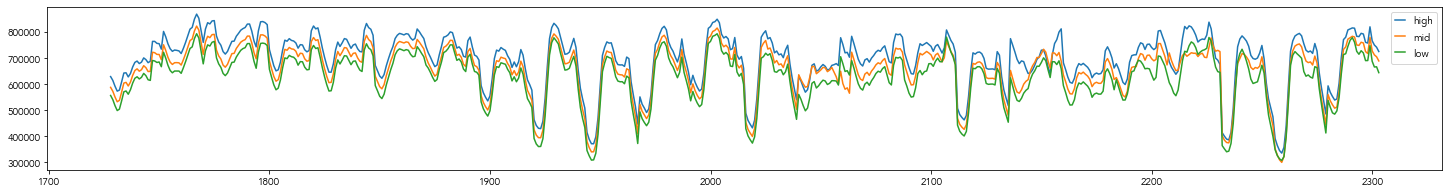

In [20]:
period = 2050

scen = 'VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDhigh'

system_load_      = _system_load(scen_labels_.loc[scen_labels_['scenario'] == scen])
system_load_high_ = system_load_.loc[system_load_['period'] == period]

scen = 'VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDmid'

system_load_     = _system_load(scen_labels_.loc[scen_labels_['scenario'] == scen])
system_load_mid_ = system_load_.loc[system_load_['period'] == period]

scen = 'VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_ICEDlow'

system_load_     = _system_load(scen_labels_.loc[scen_labels_['scenario'] == scen])
system_load_low_ = system_load_.loc[system_load_['period'] == period]

plt.figure(figsize = (25, 3))
plt.plot(system_load_high_['static_load_mw'], label = 'high')
plt.plot(system_load_mid_['static_load_mw'], label = 'mid')
plt.plot(system_load_low_['static_load_mw'], label = 'low')
plt.legend()

plt.savefig('PIER.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [21]:
print(np.max(system_load_high_['static_load_mw']))
print(np.sum(system_load_high_['static_load_mw'] * system_load_high_['timepoint_weight'])/1e6)

868360.1327243575
5993.405122174902


In [22]:
print(np.max(system_load_mid_['static_load_mw']))
print(np.sum(system_load_mid_['static_load_mw'] * system_load_mid_['timepoint_weight'])/1e6)

822529.1659114349
5638.813338453583


In [23]:
print(np.max(system_load_low_['static_load_mw']))
print(np.sum(system_load_low_['static_load_mw'] * system_load_low_['timepoint_weight'])/1e6)

793164.7947614392
5375.37568856185
